In [ ]:
# Install Required Library

!pip install numpy==1.23.5
!pip install pandas==1.5.3
!pip install matplotlib==3.7.1
!pip install earthengine-api==0.1.374
!pip install scikit-learn==1.2.2
!pip install shapely==2.0.1
!pip install geopandas==0.13.2
!pip install geemap==0.28.2
!pip install seaborn==0.12.2
!pip install xgboost==2.0.0
!pip install tqdm==4.66.1
!pip install hyperopt==0.2.7
!pip install optuna==3.3.0

In [1]:
# Basic Python Library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Geospatial Library
import ee
import geemap
from shapely.geometry import Point
import geopandas as gpd

# Machine Learning Library
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import decomposition
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn import svm
import joblib

# Hyperparameter Optimization Library
import hyperopt
from hyperopt import fmin, tpe, hp, Trials,STATUS_OK
import optuna

### Additional Library
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

<b> Use GEE Credential to login and download Satellite Data </b>

In [2]:
ee.Authenticate()

In [3]:
ee.Initialize()

In [4]:
# Change the path according to the file store in their own system
train_path = '/content/drive/MyDrive/Train.csv'
test_path = '/content/drive/MyDrive/Test.csv'

In [5]:
# Read CSV File using Pandas Library which convert into DataFrame
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [6]:
# Function to create a different Vegetation as well as Mositure/water Indices from Sentinel-2 Satellite Dataset.

def addIndices(image):

    # Normalized Difference Vegetation Index
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Normalized Difference Red-Edged Index
    ndre = image.normalizedDifference(['B8', 'B5']).rename('NDRE')

    # Soil Adjusted Vegetation Index
    savi = ee.Image().expression('((NIR-RED)/(NIR+RED+0.5))*1.5',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000)}).rename('SAVI')

    #Atmospherically Resistant Vegetation Index
    arvi = ee.Image().expression('((NIR-2*RED + BLUE)/(NIR+2*RED+BLUE))',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000),
                                 'BLUE':image.select('B2').divide(10000)}).rename('ARVI')

    # Normalized Difference Mositure Index
    ndmi = ee.Image().expression('((NIR-SWIR)/(NIR+SWIR))',\
                                 {'NIR':image.select('B8'),
                                  'SWIR':image.select('B11')}).rename('NDMI')

    # Green Condition Index
    gci = ee.Image().expression('(NIR/GREEN) - 1',\
                                {'NIR':image.select('B8').divide(10000),
                                 'GREEN':image.select('B3').divide(10000)}).rename('GCI')

    # Red Vegetation Index
    rvi = ee.Image().expression('(NIR/RED)',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000)}).rename('RVI')

    #Optimized Soil Adjusted Vegetation Index
    osavi = ee.Image().expression('((NIR-RED)/(NIR+RED+0.16))*1.16',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000)}).rename('OSAVI')

    # Specific Leaf Area Vegetation Index
    slavi = ee.Image().expression('NIR/(RED+SWIR2)',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000),
                                 'SWIR2':image.select('B12').divide(10000)}).rename('SLAVI')

    # Normalized Pigment Chlorophyll Ration Index
    npcri = ee.Image().expression('((RED-BLUE)/(BLUE+RED))',\
                                {'BLUE':image.select('B2'),
                                 'RED':image.select('B4')}).rename('NPCRI')

    #Soil Condition Index
    sci = ee.Image().expression('((SWIR-NIR)/(SWIR+NIR))',\
                                {'NIR':image.select('B8'),
                                 'SWIR':image.select('B11')}).rename('SCI')

    # Normalized Difference Water Index
    ndwi = ee.Image().expression('((GREEN-NIR)/(GREEN+NIR))',\
                                 {'NIR':image.select('B8').divide(10000),
                                  'GREEN':image.select('B3').divide(10000)}).rename('NDWI')

    # Green Normalized Difference Vegetaion Index
    gndvi = ee.Image().expression('((NIR-GREEN)/(GREEN+NIR))',\
                                {'NIR':image.select('B8'),
                                 'GREEN':image.select('B3')}).rename('GNDVI')

    # Bare soil Index
    bsi = ee.Image().expression('((SWIR+RED)-(NIR+BLUE))/((SWIR+RED)+(NIR+BLUE))',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000),
                                 'BLUE':image.select('B2').divide(10000),
                                 'SWIR':image.select('B11').divide(10000)}).rename('BSI')

    # Enhanced Vegetation Index
    evi = ee.Image().expression('((2.5*(NIR-RED))/(NIR+6*RED-7.5*BLUE+1))',\
                                {'NIR':image.select('B8').divide(10000),
                                 'RED':image.select('B4').divide(10000),
                                 'BLUE':image.select('B2').divide(10000)}).rename('EVI')


    return image.addBands(ndvi).addBands(ndre).addBands(savi).addBands(arvi).addBands(ndwi).addBands(gci).addBands(rvi).addBands(osavi).addBands(slavi).addBands(npcri).addBands(sci).addBands(ndmi).addBands(gndvi).addBands(bsi).addBands(evi)

*The training and test CSV files contain latitude and longitude coordinates, along with labels, except in the test file. These will be converted into a point shapefile, which will be utilized in the Google Earth Engine (GEE) as a labeled training dataset.*

In [7]:
def csv_to_geopandas(df):
    points = []
    for idx,row in df.iterrows():
        point = Point([row['Lon'],row['Lat']])
        points.append(point)

    gdf = gpd.GeoDataFrame(df,geometry=points)
    gdf = gdf.drop(columns=['Lat','Lon'])
    gdf.set_crs(epsg=4326,inplace=True)  # WGS84 Coordinate System
    return gdf

trainGDF = csv_to_geopandas(train)
testGDF = csv_to_geopandas(test)
trainGDF.head()

,ID,Target,geometry
0,ID_SJ098E7S2SY9,0,POINT (70.76367 34.16249)
1,ID_CWCD60FGJJYY,0,POINT (48.49205 32.07570)
2,ID_R1XF70RMVGL3,1,POINT (33.31348 14.54283)
3,ID_0ZBIDY0PEBVO,1,POINT (33.28411 14.35948)
4,ID_C20R2C0AYIT0,0,POINT (33.52845 14.41913)


0 : Non-Crop Label

1 : Crop Label

In [9]:
#Sudan Area of Interest (AOI)
aoi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")\
        .filter(ee.Filter.eq('ADM0_NAME','Sudan'))

In [12]:
# GEE Provide Sentinel-2 Dataset along with Cloud Probability Dataset which can mask the pixel on the basis of Threshold Probability

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
s2c = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')

# Define dates over which to create a composite.
start = ee.Date('2019-08-01')
end = ee.Date('2020-07-01')

# Define a collection filtering function.
def filterBoundsDate(imgCol, aoi, start, end):
    return imgCol.filterBounds(aoi).filterDate(start, end)

# Filter the collection by AOI and date.
s2 = filterBoundsDate(s2, aoi, start, end)
s2c = filterBoundsDate(s2c, aoi, start, end)

# Define a function to join the two collections on their 'system:index'
# property. The 'propName' parameter is the name of the property that
# references the joined image.
def indexJoin(colA, colB, propName):
    joined = ee.ImageCollection(ee.Join.saveFirst(propName).apply(**{
        'primary': colA,
        'secondary': colB,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

    def func_mti(image):
        return image.addBands(ee.Image(image.get(propName)))
    return joined.map(func_mti)

# Define a function to create a cloud masking function.
def buildMaskFunction(img):
    cloudProb = 50
    # Define clouds as pixels having greater than the given cloud probability.
    cloud = img.select('probability').gt(ee.Image(cloudProb))

    # Apply the cloud mask to the image and return it.
    return img.updateMask(cloud.Not())

# Join the cloud probability collection to the TOA reflectance collection.
withCloudProbability = indexJoin(s2, s2c, 'cloud_probability')

# Map the cloud masking function over the joined collection, select only the
# reflectance bands.

s2collection = ee.ImageCollection(withCloudProbability.map(buildMaskFunction)).map(addIndices)

In [13]:
s2collection = s2collection.select(['NDVI','NDRE','SAVI', 'ARVI', 'NDWI', 'GCI', 'RVI',
                                    'OSAVI', 'SLAVI', 'NPCRI', 'SCI', 'NDMI', 'GNDVI', 'BSI', 'EVI'])

In [14]:
def monthlist(start_date, end_date):
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    date_generated = [start + timedelta(days=x) for x in range(0, (end-start).days)]

    unique_months = []
    for date in date_generated:
        if (date.year, date.month) not in unique_months:
            unique_months.append((date.year, date.month))

    return unique_months

def monthlyCompositeData(collection,startDate,endDate):
    unique_months = monthlist(startDate,endDate)
    monthly_composites = []

    for (year, month) in unique_months:
        start_date = ee.Date.fromYMD(year, month, 1)
        end_date = start_date.advance(1, 'month')

        filtered = collection.filterDate(start_date, end_date)

        monthly_composite = filtered.mean().set('year', year).set('month', month)

        monthly_composites.append(monthly_composite)
    
    return monthly_composites

monthlyComposites = monthlyCompositeData(s2collection,'2019-08-01','2020-07-01')
monthlyComposites = ee.ImageCollection.fromImages(monthlyComposites)

In [15]:
# ImageCollection to Single Image where Temporal Dataset of Monthly Composite Image goes to N Number Bands
combinedImage = monthlyComposites.toBands()

In [16]:
print('BandName :',combinedImage.bandNames().getInfo())

BandName : ['0_NDVI', '0_NDRE', '0_SAVI', '0_ARVI', '0_NDWI', '0_GCI', '0_RVI', '0_OSAVI', '0_SLAVI', '0_NPCRI', '0_SCI', '0_NDMI', '0_GNDVI', '0_BSI', '0_EVI', '1_NDVI', '1_NDRE', '1_SAVI', '1_ARVI', '1_NDWI', '1_GCI', '1_RVI', '1_OSAVI', '1_SLAVI', '1_NPCRI', '1_SCI', '1_NDMI', '1_GNDVI', '1_BSI', '1_EVI', '2_NDVI', '2_NDRE', '2_SAVI', '2_ARVI', '2_NDWI', '2_GCI', '2_RVI', '2_OSAVI', '2_SLAVI', '2_NPCRI', '2_SCI', '2_NDMI', '2_GNDVI', '2_BSI', '2_EVI', '3_NDVI', '3_NDRE', '3_SAVI', '3_ARVI', '3_NDWI', '3_GCI', '3_RVI', '3_OSAVI', '3_SLAVI', '3_NPCRI', '3_SCI', '3_NDMI', '3_GNDVI', '3_BSI', '3_EVI', '4_NDVI', '4_NDRE', '4_SAVI', '4_ARVI', '4_NDWI', '4_GCI', '4_RVI', '4_OSAVI', '4_SLAVI', '4_NPCRI', '4_SCI', '4_NDMI', '4_GNDVI', '4_BSI', '4_EVI', '5_NDVI', '5_NDRE', '5_SAVI', '5_ARVI', '5_NDWI', '5_GCI', '5_RVI', '5_OSAVI', '5_SLAVI', '5_NPCRI', '5_SCI', '5_NDMI', '5_GNDVI', '5_BSI', '5_EVI', '6_NDVI', '6_NDRE', '6_SAVI', '6_ARVI', '6_NDWI', '6_GCI', '6_RVI', '6_OSAVI', '6_SLAVI', '6_N

Prefix Attached to Indices


- 0 : August, 209  
- 1 : September,2019
- 2 : October,2019
- 3 : November,2019
- 4 : December,2019
- 5 : January,2020
- 6 : Februrary,2020
- 7 : March,2020
- 8 : April,2020
- 9 : May,2020
- 10 : June,2020 

In [17]:
# Shapefile conversion to GEE Feature and FeatureCollection

def geopandas_to_ee(gdf):
    features = []
    for idx, row in gdf.iterrows():
        geo = row['geometry']
        properties = row.drop('geometry').to_dict()
        features.append(ee.Feature(ee.Geometry(geo.__geo_interface__),properties))
    return ee.FeatureCollection(features)

trainEE = geopandas_to_ee(trainGDF)
testEE = geopandas_to_ee(testGDF)
#print(trainEE.first().getInfo())

In [18]:
# There are a total of 1500 sample points each in both the training and test datasets.
# To use only the Afghanistan Ground Truth sample points, employ the filterBounds technique
# to select sample points from the specified region.

trainEE = trainEE.filterBounds(aoi)
testEE = testEE.filterBounds(aoi)

In [19]:
# Extract Sentinel-2 Satellite Indices from a given location

def calculateMetrics(block):
    metrics = combinedImage.reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': block.geometry(),
        'scale':10, # Spatial Resolution of Sentinel-2
     })
    return ee.Feature(None,metrics).copyProperties(block, ['ID','Target'])

trainEE = trainEE.map(calculateMetrics)
testEE = testEE.map(calculateMetrics)

*The steps below are to convert the Google Earth Engine (GEE) FeatureCollection into a Pandas DataFrame, which will subsequently be used for analysis and model development.*

In [20]:
train_samples,test_samples = [],[]

In [21]:
for item in trainEE.getInfo()['features']:
    train_samples.append(item['properties'])

In [22]:
for item in testEE.getInfo()['features']:
    test_samples.append(item['properties'])

In [23]:
train_samples_df = pd.DataFrame(train_samples)
test_samples_df = pd.DataFrame(test_samples)

In [24]:
train_samples_df.head()

,0_ARVI,0_BSI,0_EVI,0_GCI,0_GNDVI,0_NDMI,0_NDRE,0_NDVI,0_NDWI,0_NPCRI,...,9_NDVI,9_NDWI,9_NPCRI,9_OSAVI,9_RVI,9_SAVI,9_SCI,9_SLAVI,ID,Target
0,0.079198,0.088843,0.158852,0.914730,0.309938,-0.032777,0.146652,0.253730,-0.309938,0.208129,...,0.221988,-0.356945,0.336841,0.197857,1.573089,0.171459,-0.067845,0.758864,ID_R1XF70RMVGL3,1
1,-0.026083,-0.034340,0.064189,0.407006,0.161360,0.251639,0.003261,0.098626,-0.161360,0.199923,...,0.102382,-0.252118,0.320232,0.081208,1.228546,0.062882,0.043544,0.565979,ID_0ZBIDY0PEBVO,1
2,-0.043028,0.126452,0.081354,0.567670,0.220819,-0.042977,0.048761,0.112487,-0.220819,0.265188,...,0.090662,-0.205094,0.285541,0.079949,1.200504,0.068504,0.057327,0.529966,ID_C20R2C0AYIT0,0
3,0.186373,-0.039012,0.236431,0.983466,0.294194,0.093077,0.228115,0.326204,-0.294194,0.084428,...,0.210706,-0.280410,0.229571,0.171011,1.534342,0.135009,0.046119,0.634374,ID_MMU0PFMDQ7FW,0
4,-0.024333,0.017793,0.078758,0.480625,0.183218,0.157559,0.044927,0.122107,-0.183218,0.238511,...,0.121346,-0.273613,0.319161,0.102656,1.276759,0.084339,0.062434,0.583184,ID_FA7TDFAUVU2A,1


In [25]:
test_samples_df.head()

,0_ARVI,0_BSI,0_EVI,0_GCI,0_GNDVI,0_NDMI,0_NDRE,0_NDVI,0_NDWI,0_NPCRI,...,9_NDRE,9_NDVI,9_NDWI,9_NPCRI,9_OSAVI,9_RVI,9_SAVI,9_SCI,9_SLAVI,ID
0,-0.003421,0.061450,0.095443,0.618579,0.235343,0.049423,0.057361,0.152754,-0.235343,0.231126,...,0.061461,0.132471,-0.271306,0.311840,0.103809,1.306373,0.079564,0.097874,0.551165,ID_SOYSG7W04UH3
1,0.138117,-0.065468,0.166169,0.782946,0.277432,0.174396,0.145849,0.296621,-0.277432,0.120502,...,0.072596,0.106986,-0.247551,0.298276,0.080963,1.240415,0.060291,0.074406,0.552929,ID_EAP7EXXV8ZDE
2,0.007632,0.172994,0.118521,1.023173,0.337128,-0.112335,0.069443,0.199898,-0.337128,0.306432,...,0.063162,0.137483,-0.286142,0.301966,0.117405,1.319507,0.097297,0.119523,0.526732,ID_QPRX1TUQVGHU
3,0.199291,-0.173378,0.281166,1.562876,0.428269,0.349517,0.251659,0.391706,-0.428269,0.190896,...,0.121059,0.181992,-0.304486,0.307477,0.145194,1.452041,0.112890,-0.091266,0.727727,ID_C78YQ32G1KO9
4,-0.034541,0.107649,0.039638,0.522863,0.204021,-0.037767,0.001038,0.098870,-0.204021,0.215766,...,0.038920,0.107146,-0.245225,0.288472,0.074661,1.241277,0.052396,0.140747,0.472835,ID_M5X39UIEM64N


*Save the pandas dataframe to csv file*

In [26]:
#train_samples_df.to_csv('IranTraining.csv',index=False)
#test_samples_df.to_csv('IranTesting.csv',index=False)

<b> Model Development </b>

In [27]:
# Reproducible  Results
import random

seed = 2023

random.seed(seed)
np.random.seed(seed)

In [29]:
indices = ['NDVI','NDRE','SAVI', 'ARVI', 'NDWI', 'GCI', 'RVI','OSAVI', 'SLAVI', 
           'NPCRI', 'SCI', 'NDMI', 'GNDVI', 'BSI', 'EVI']

drop_cols = [f'2_{col}' for col in indices]  # Drop December Month Data, as most of the Samples contains NaN values
drop_cols.extend(['ID','Target'])

X = train_samples_df.drop(drop_cols,axis=1)
y = train_samples_df[['Target']]

selected_indices = ['NDVI','NDRE','ARVI', 'RVI','SCI', 'NDMI', 'GNDVI', 'BSI']
temporal_indices = []

for m in range(0,11):
    if m == 2:
        continue
    else:
        temporal_indices.extend([f'{m}_{col}' for col in selected_indices])
    
temporal_indices

['0_NDVI',
 '0_NDRE',
 '0_ARVI',
 '0_RVI',
 '0_SCI',
 '0_NDMI',
 '0_GNDVI',
 '0_BSI',
 '1_NDVI',
 '1_NDRE',
 '1_ARVI',
 '1_RVI',
 '1_SCI',
 '1_NDMI',
 '1_GNDVI',
 '1_BSI',
 '3_NDVI',
 '3_NDRE',
 '3_ARVI',
 '3_RVI',
 '3_SCI',
 '3_NDMI',
 '3_GNDVI',
 '3_BSI',
 '4_NDVI',
 '4_NDRE',
 '4_ARVI',
 '4_RVI',
 '4_SCI',
 '4_NDMI',
 '4_GNDVI',
 '4_BSI',
 '5_NDVI',
 '5_NDRE',
 '5_ARVI',
 '5_RVI',
 '5_SCI',
 '5_NDMI',
 '5_GNDVI',
 '5_BSI',
 '6_NDVI',
 '6_NDRE',
 '6_ARVI',
 '6_RVI',
 '6_SCI',
 '6_NDMI',
 '6_GNDVI',
 '6_BSI',
 '7_NDVI',
 '7_NDRE',
 '7_ARVI',
 '7_RVI',
 '7_SCI',
 '7_NDMI',
 '7_GNDVI',
 '7_BSI',
 '8_NDVI',
 '8_NDRE',
 '8_ARVI',
 '8_RVI',
 '8_SCI',
 '8_NDMI',
 '8_GNDVI',
 '8_BSI',
 '9_NDVI',
 '9_NDRE',
 '9_ARVI',
 '9_RVI',
 '9_SCI',
 '9_NDMI',
 '9_GNDVI',
 '9_BSI',
 '10_NDVI',
 '10_NDRE',
 '10_ARVI',
 '10_RVI',
 '10_SCI',
 '10_NDMI',
 '10_GNDVI',
 '10_BSI']

In [30]:
X = train_samples_df.loc[:,temporal_indices]
y = train_samples_df[['Target']]

X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.3,
                                                                 random_state=2023,stratify=train_samples_df[['Target']])

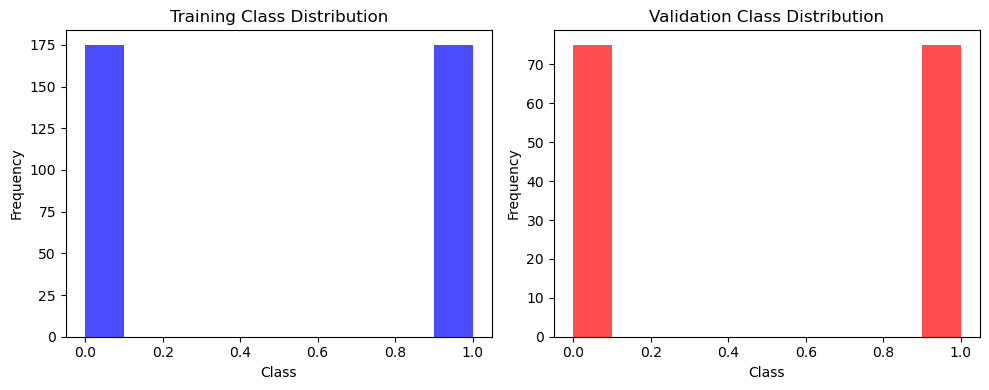

In [31]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
# Plot the first histogram on the left subplot
axs[0].hist(y_train, color='blue', alpha=0.7)
axs[0].set_title("Training Class Distribution")
axs[0].set_xlabel("Class")
axs[0].set_ylabel("Frequency")

# Plot the second histogram on the right subplot
axs[1].hist(y_test, color='red', alpha=0.7)
axs[1].set_title("Validation Class Distribution")
axs[1].set_xlabel("Class")
axs[1].set_ylabel("Frequency")

# Display the plots
plt.tight_layout()
plt.show()

In [32]:
print('Training size: ',X_train.shape[0])
print('Testing size: ',X_test.shape[0])

Training size:  350
Testing size:  150


In [33]:
# Score to measure the performance of the model during Hyperparameter Optimization

def custom_score(y_true, y_prob):
    # Compute ROC curve values
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    
    # Calculate the Euclidean distance for each point on the ROC curve to the top-left corner (0,1)
    distances = np.sqrt((0 - fpr)**2 + (1 - tpr)**2)
    
    # Get the threshold for the minimum distance point
    optimal_threshold = thresholds[np.argmin(distances)]
    
    # Reclassify based on the optimal threshold
    y_pred_optimal = (y_prob >= optimal_threshold).astype(int)
    
    # Compute F1 score using the optimal threshold; you can use other metrics if needed
    return metrics.f1_score(y_true, y_pred_optimal)

# Create a custom scorer
custom_scorer = metrics.make_scorer(custom_score, needs_proba=True)

### Decision Tree

In [34]:
dt_clf = tree.DecisionTreeClassifier(random_state=2023)
dt_clf.fit(X_train,y_train.values.ravel())
y_pred = dt_clf.predict(X_test)

print('Overall Accuracy on Test Data',metrics.accuracy_score(y_pred,y_test.values.ravel()))
print('Precision on Test Data',metrics.precision_score(y_pred,y_test.values.ravel()))
print('Recall score on Test Data',metrics.recall_score(y_pred,y_test.values.ravel()))
print('F1-Score on Test Data',metrics.f1_score(y_pred,y_test.values.ravel()))

Overall Accuracy on Test Data 0.8933333333333333
Precision on Test Data 0.8933333333333333
Recall score on Test Data 0.8933333333333333
F1-Score on Test Data 0.8933333333333333


### Confusion Matrix

- Classifier Evaluation: Assessing the performance of classification models in various domains like healthcare, finance, and more.
- Model Tuning: Identifying where the model is going wrong (e.g., which classes are being misclassified) to guide further tuning.
- Decision Making: Aiding stakeholders in understanding the model's performance and making informed decisions.

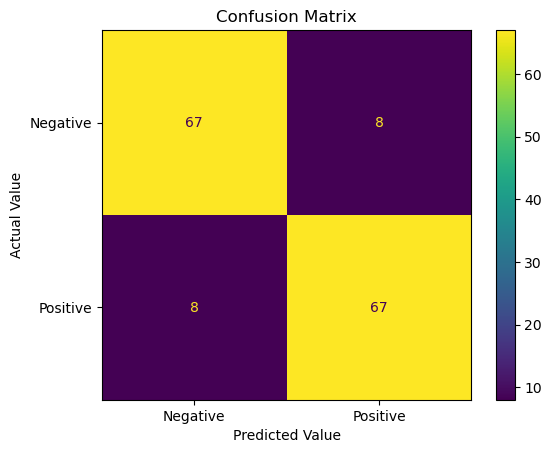

In [35]:
cm = metrics.confusion_matrix(y_test.values.ravel(), y_pred, labels=dt_clf.classes_)
cmplot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative', 'Positive'])
cmplot.plot()
cmplot.ax_.set(title='Confusion Matrix',xlabel='Predicted Value', ylabel='Actual Value')
plt.show()

- <b> Negative: Non-Crop </b>
- <b> Positive: Crop </b>

In [36]:
#### Using cross validation to improve the Accuracy

dt_clf = tree.DecisionTreeClassifier(random_state=2023)
scores = model_selection.cross_val_score(dt_clf, X_train, y_train.values.ravel(),scoring='f1', cv=5)
print(scores)

[0.88571429 0.94117647 0.90410959 0.97142857 0.88571429]


##### Grid Search CV
Grid Search Cross-Validation is a systematic approach to tuning the hyperparameters of a machine learning model. It performs an exhaustive search through a specified subset of hyperparameters and finds the best combination of parameters that minimizes a predefined loss function or maximizes the accuracy.

In [37]:
param_grid = {
    'max_depth': [3, 5,7,11,13],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
    'criterion': ['gini', 'entropy']
}
inner_cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=2023)
gcv = model_selection.GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=2023),
                       param_grid=param_grid,
                       scoring=custom_scorer,
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)

X_train_cv = X_train.reset_index(drop=True)
y_train_cv = y_train.reset_index(drop=True)

In [38]:
outer_scores = []

outer_cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)
    
    
for train_idx, valid_idx in outer_cv.split(X_train_cv, y_train_cv):
    gcv.fit(X_train_cv.loc[train_idx,:], y_train_cv.loc[train_idx,:].values.ravel()) # run inner loop hyperparam tuning
    print('\n Best ACC (avg. of inner test folds) %.2f%%' % (gcv.best_score_ * 100))
    print('Best parameters:', gcv.best_params_)
        
    # perf on test fold (valid_idx)
    outer_scores.append(gcv.best_estimator_.score(X_train_cv.loc[valid_idx,:], y_train_cv.loc[valid_idx,:].values.ravel()))
    print('ACC (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
    
print('\n    Outer Loop:')
print('ACC %.2f%% +/- %.2f' % (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))


 Best ACC (avg. of inner test folds) 92.42%
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
ACC (on outer test fold) 91.43%

 Best ACC (avg. of inner test folds) 89.90%
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
ACC (on outer test fold) 97.14%

 Best ACC (avg. of inner test folds) 95.71%
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
ACC (on outer test fold) 92.86%

 Best ACC (avg. of inner test folds) 92.93%
Best parameters: {'criterion': 'gini', 'max_depth': 7, 'max_leaf_nodes': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
ACC (on outer test fold) 92.86%

 Best ACC (avg. of inner test folds) 91.99%
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
ACC (on 

In [39]:
print('Best Parameter',gcv.best_params_)

Best Parameter {'criterion': 'gini', 'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [41]:
dt_clf = tree.DecisionTreeClassifier(**{'criterion': 'entropy', 'max_depth': 3, 
                                        'max_leaf_nodes': 10, 'min_samples_leaf': 4, 
                                        'min_samples_split': 2},random_state=2023)

dt_clf.fit(X_train,y_train.values.ravel())
y_pred = dt_clf.predict(X_test)

print('Overall Accuracy on Test Data',metrics.accuracy_score(y_pred,y_test.values.ravel()))
print('Precision on Test Data',metrics.precision_score(y_pred,y_test.values.ravel()))
print('Recall score on Test Data',metrics.recall_score(y_pred,y_test.values.ravel()))
print('F1-Score on Test Data',metrics.f1_score(y_pred,y_test.values.ravel()))

Overall Accuracy on Test Data 0.9266666666666666
Precision on Test Data 0.96
Recall score on Test Data 0.9
F1-Score on Test Data 0.9290322580645162


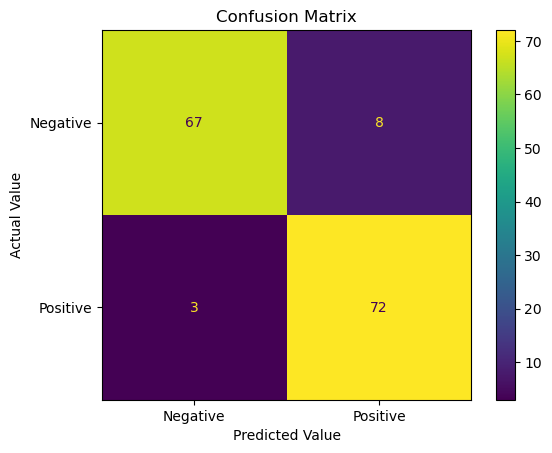

In [42]:
cm = metrics.confusion_matrix(y_test.values.ravel(), y_pred, labels=dt_clf.classes_)
cmplot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative', 'Positive'])
cmplot.plot()
cmplot.ax_.set(title='Confusion Matrix',xlabel='Predicted Value', ylabel='Actual Value')
plt.show()

In [43]:
### Another Library to search best hyperparameter in a given space using Hyperopt Library

In [44]:
space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
}

# Define the objective function
def objective(params):
    params = {
        'criterion': params['criterion'],
        'max_depth': int(params['max_depth']),
        'min_samples_split': int(params['min_samples_split']),
        'min_samples_leaf': int(params['min_samples_leaf'])
    }
    
    clf = tree.DecisionTreeClassifier(**params)
    score = model_selection.cross_val_score(clf, X_train,y_train.values.ravel(), cv=5,scoring=custom_scorer).mean()

    return {'loss': -score, 'status': hyperopt.STATUS_OK}

# Run the optimizer
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████████████████████████████| 100/100 [00:05<00:00, 17.96trial/s, best loss: -0.9544999030160486]


In [45]:
print(best)

{'criterion': 1, 'max_depth': 4.0, 'min_samples_leaf': 1.0, 'min_samples_split': 6.0}


In [46]:
dt_clf = tree.DecisionTreeClassifier(**{'criterion': 'entropy', 
                                     'max_depth': 9, 'min_samples_leaf': 3, 
                                     'min_samples_split':8},random_state=2023)

dt_clf.fit(X_train,y_train.values.ravel())
y_pred = dt_clf.predict(X_test)

print('Overall Accuracy on Test Data',metrics.accuracy_score(y_pred,y_test.values.ravel()))
print('Precision on Test Data',metrics.precision_score(y_pred,y_test.values.ravel()))
print('Recall score on Test Data',metrics.recall_score(y_pred,y_test.values.ravel()))
print('F1-Score on Test Data',metrics.f1_score(y_pred,y_test.values.ravel()))

Overall Accuracy on Test Data 0.9133333333333333
Precision on Test Data 0.9066666666666666
Recall score on Test Data 0.918918918918919
F1-Score on Test Data 0.912751677852349


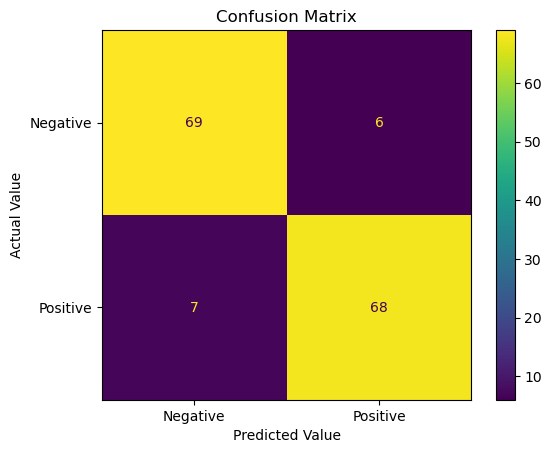

In [47]:
cm = metrics.confusion_matrix(y_test.values.ravel(), y_pred, labels=dt_clf.classes_)
cmplot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative', 'Positive'])
cmplot.plot()
cmplot.ax_.set(title='Confusion Matrix',xlabel='Predicted Value', ylabel='Actual Value')
plt.show()

In [48]:
#### Optuna Library

# Define the objective function
def objective(trial):
    # Define hyperparameter search space using trial object
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depth = trial.suggest_int('max_depth', 1, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    clf = tree.DecisionTreeClassifier(
        criterion=criterion, 
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    return 1.0 - model_selection.cross_val_score(clf, X_train, y_train.values.ravel(), cv=5,scoring=custom_scorer).mean()

# Create a study object and specify the direction is 'minimize'.
study = optuna.create_study(direction='minimize')

# Optimize the study, the objective function is passed in as the first argument.
study.optimize(objective, n_trials=100)

[I 2023-10-14 08:24:35,255] A new study created in memory with name: no-name-eab021c9-873a-48ba-956f-4f53f7c929a9
[I 2023-10-14 08:24:35,344] Trial 0 finished with value: 0.06215292549420004 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.06215292549420004.
[I 2023-10-14 08:24:35,417] Trial 1 finished with value: 0.06874055929781586 and parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.06215292549420004.
[I 2023-10-14 08:24:35,487] Trial 2 finished with value: 0.050240193060953287 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.050240193060953287.
[I 2023-10-14 08:24:35,542] Trial 3 finished with value: 0.06793903517724709 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 2

[I 2023-10-14 08:24:37,450] Trial 35 finished with value: 0.05400625978090756 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.044916163648558105.
[I 2023-10-14 08:24:37,514] Trial 36 finished with value: 0.08540722596448236 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.044916163648558105.
[I 2023-10-14 08:24:37,578] Trial 37 finished with value: 0.062384451637360394 and parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.044916163648558105.
[I 2023-10-14 08:24:37,645] Trial 38 finished with value: 0.0536038452939861 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.044916163648558105.
[I 2023-10-14 08:24:37,695] Trial 39 finished with value: 0.1131802

[I 2023-10-14 08:24:39,802] Trial 71 finished with value: 0.05277110907013027 and parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 53 with value: 0.04202423061963878.
[I 2023-10-14 08:24:39,868] Trial 72 finished with value: 0.05095588020878883 and parameters: {'criterion': 'entropy', 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 53 with value: 0.04202423061963878.
[I 2023-10-14 08:24:39,935] Trial 73 finished with value: 0.05645887102111047 and parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 53 with value: 0.04202423061963878.
[I 2023-10-14 08:24:40,001] Trial 74 finished with value: 0.05332456680282771 and parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.04202423061963878.
[I 2023-10-14 08:24:40,068] Trial 75 finished with value: 0.0

In [49]:
best_params = study.best_params
print('Best Paramter: ',best_params)
best_score = 1.0 - study.best_value
print('Best score: ',best_score)

Best Paramter:  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 5}
Best score:  0.9579757693803612


In [50]:
dt_clf = tree.DecisionTreeClassifier(**{'criterion': 'entropy', 
                                        'max_depth': 14, 'min_samples_split': 10, 
                                        'min_samples_leaf': 4},random_state=2023)

dt_clf.fit(X_train,y_train.values.ravel())

y_pred = dt_clf.predict(X_test)

print('Overall Accuracy on Test Data',metrics.accuracy_score(y_pred,y_test.values.ravel()))
print('Precision on Test Data',metrics.precision_score(y_pred,y_test.values.ravel()))
print('Recall score on Test Data',metrics.recall_score(y_pred,y_test.values.ravel()))
print('F1-Score on Test Data',metrics.f1_score(y_pred,y_test.values.ravel()))

Overall Accuracy on Test Data 0.9133333333333333
Precision on Test Data 0.9066666666666666
Recall score on Test Data 0.918918918918919
F1-Score on Test Data 0.912751677852349


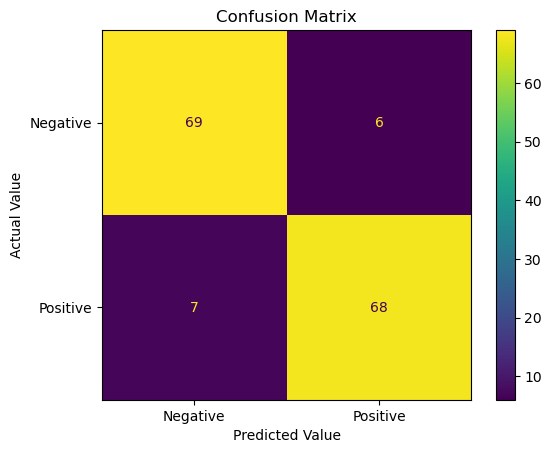

In [51]:
cm = metrics.confusion_matrix(y_test.values.ravel(), y_pred, labels=dt_clf.classes_)
cmplot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative', 'Positive'])
cmplot.plot()
cmplot.ax_.set(title='Confusion Matrix',xlabel='Predicted Value', ylabel='Actual Value')
plt.show()

### Random Forest

In [52]:
rf_clf = ensemble.RandomForestClassifier(random_state=2023)
rf_clf.fit(X_train,y_train.values.ravel())
y_pred = rf_clf.predict(X_test)

print('Overall Accuracy on Test Data',metrics.accuracy_score(y_pred,y_test.values.ravel()))
print('Precision on Test Data',metrics.precision_score(y_pred,y_test.values.ravel()))
print('Recall score on Test Data',metrics.recall_score(y_pred,y_test.values.ravel()))
print('F1-Score on Test Data',metrics.f1_score(y_pred,y_test.values.ravel()))

Overall Accuracy on Test Data 0.9866666666666667
Precision on Test Data 0.9866666666666667
Recall score on Test Data 0.9866666666666667
F1-Score on Test Data 0.9866666666666668


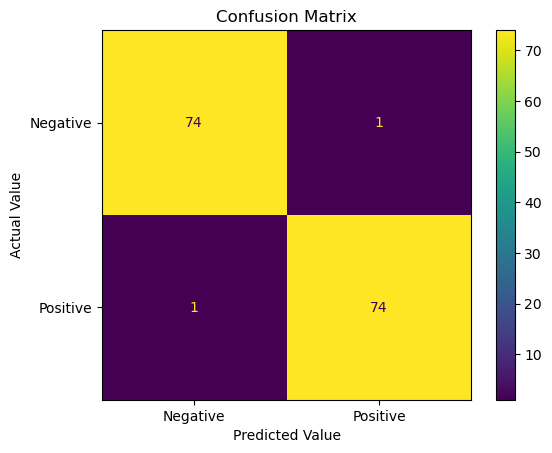

In [53]:
cm = metrics.confusion_matrix(y_test.values.ravel(), y_pred, labels=rf_clf.classes_)
cmplot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative', 'Positive'])
cmplot.plot()
cmplot.ax_.set(title='Confusion Matrix',xlabel='Predicted Value', ylabel='Actual Value')
plt.show()

In [54]:
#### Using cross validation to improve the Accuracy

rf_clf = ensemble.RandomForestClassifier(random_state=2023)
scores = model_selection.cross_val_score(rf_clf, X_train, y_train.values.ravel(),scoring='f1', cv=5)
print(scores)

[0.94285714 0.98591549 0.95652174 1.         0.95522388]


### Grid Search CV

In [55]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}
inner_cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=2023)
gcv = model_selection.GridSearchCV(estimator=ensemble.RandomForestClassifier(random_state=2023),
                       param_grid=param_grid,
                       scoring=custom_scorer,
                       n_jobs=-1,
                       cv=inner_cv,
                       verbose=0,
                       refit=True)
X_train_cv = X_train.reset_index(drop=True)
y_train_cv = y_train.reset_index(drop=True)

In [56]:
outer_scores = []

outer_cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)
    
    
for train_idx, valid_idx in outer_cv.split(X_train_cv, y_train_cv):
    gcv.fit(X_train_cv.loc[train_idx,:], y_train_cv.loc[train_idx,:].values.ravel()) # run inner loop hyperparam tuning
    print('\n Best ACC (avg. of inner test folds) %.2f%%' % (gcv.best_score_ * 100))
    print('Best parameters:', gcv.best_params_)
        
    # perf on test fold (valid_idx)
    outer_scores.append(gcv.best_estimator_.score(X_train_cv.loc[valid_idx,:], y_train_cv.loc[valid_idx,:].values.ravel()))
    print('ACC (on outer test fold) %.2f%%' % (outer_scores[-1]*100))
    
print('\n    Outer Loop:')
print('ACC %.2f%% +/- %.2f' % (np.mean(outer_scores) * 100, np.std(outer_scores) * 100))


 Best ACC (avg. of inner test folds) 98.57%
Best parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
ACC (on outer test fold) 98.57%

 Best ACC (avg. of inner test folds) 97.85%
Best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
ACC (on outer test fold) 97.14%

 Best ACC (avg. of inner test folds) 99.29%
Best parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}
ACC (on outer test fold) 94.29%

 Best ACC (avg. of inner test folds) 97.89%
Best parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
ACC (on outer test fold) 98.57%

 Best ACC (avg. of inner test folds) 97.86%
Best parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}
ACC (on outer test fold) 100.0

In [57]:
print('Best Parameter',gcv.best_params_)

Best Parameter {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}


In [58]:
rf_clf = ensemble.RandomForestClassifier(**{'bootstrap': True, 
                                            'criterion': 'entropy', 
                                            'max_depth': None, 
                                            'max_features': 'log2', 'n_estimators': 100},random_state=2023)

rf_clf.fit(X_train,y_train.values.ravel())
y_pred = rf_clf.predict(X_test)

print('Overall Accuracy on Test Data',metrics.accuracy_score(y_pred,y_test.values.ravel()))
print('Precision on Test Data',metrics.precision_score(y_pred,y_test.values.ravel()))
print('Recall score on Test Data',metrics.recall_score(y_pred,y_test.values.ravel()))
print('F1-Score on Test Data',metrics.f1_score(y_pred,y_test.values.ravel()))

Overall Accuracy on Test Data 0.9933333333333333
Precision on Test Data 0.9866666666666667
Recall score on Test Data 1.0
F1-Score on Test Data 0.9932885906040269


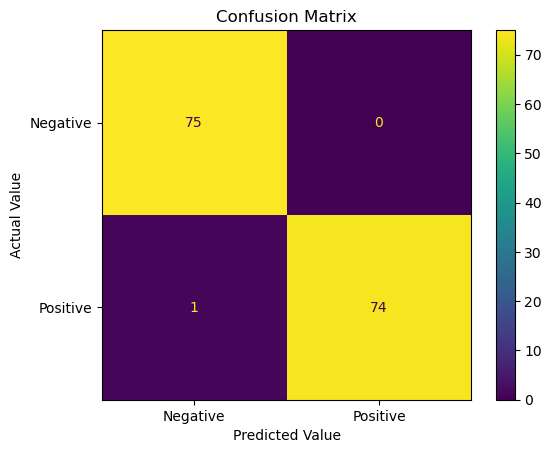

In [59]:
cm = metrics.confusion_matrix(y_test.values.ravel(), y_pred, labels=rf_clf.classes_)
cmplot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative', 'Positive'])
cmplot.plot()
cmplot.ax_.set(title='Confusion Matrix',xlabel='Predicted Value', ylabel='Actual Value')
plt.show()

In [60]:
### Hyperopt Library

In [61]:
# Define the objective function
def objective(params):
    clf = ensemble.RandomForestClassifier(**params)
    score = model_selection.cross_val_score(clf, X_train,y_train.values.ravel(), cv=5,scoring=custom_scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 200]),
    'max_features': hp.choice('max_features', ['sqrt', 'log2']),
    'max_depth': hp.choice('max_depth', [None, 10, 20, 30, 40, 50]),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████████████████████████████| 100/100 [01:07<00:00,  1.49trial/s, best loss: -0.9914676464584609]


In [62]:
print("Best hyperparameters:", best)

Best hyperparameters: {'bootstrap': 1, 'criterion': 1, 'max_depth': 1, 'max_features': 1, 'n_estimators': 3}


In [63]:
rf_clf = ensemble.RandomForestClassifier(**{'bootstrap': False, 
                                            'criterion': 'entropy', 
                                            'max_depth': 3, 
                                            'max_features': 'log2', 
                                            'n_estimators': 1},random_state=2023)

rf_clf.fit(X_train,y_train.values.ravel())

y_pred = rf_clf.predict(X_test)

print('Overall Accuracy on Test Data',metrics.accuracy_score(y_pred,y_test.values.ravel()))
print('Precision on Test Data',metrics.precision_score(y_pred,y_test.values.ravel()))
print('Recall score on Test Data',metrics.recall_score(y_pred,y_test.values.ravel()))
print('F1-Score on Test Data',metrics.f1_score(y_pred,y_test.values.ravel()))

Overall Accuracy on Test Data 0.86
Precision on Test Data 0.8266666666666667
Recall score on Test Data 0.8857142857142857
F1-Score on Test Data 0.8551724137931035


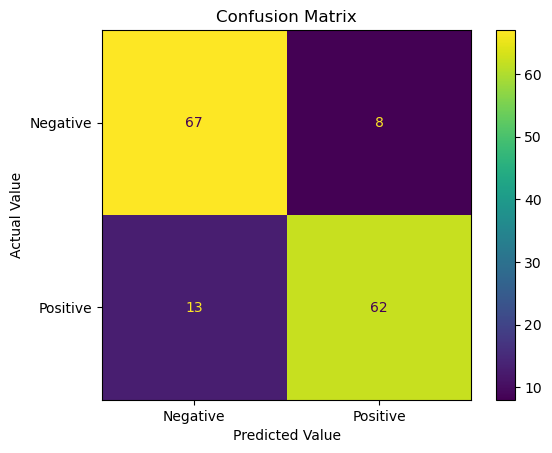

In [64]:
cm = metrics.confusion_matrix(y_test.values.ravel(), y_pred, labels=rf_clf.classes_)
cmplot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative', 'Positive'])
cmplot.plot()
cmplot.ax_.set(title='Confusion Matrix',xlabel='Predicted Value', ylabel='Actual Value')
plt.show()

In [67]:
### Optuna Library

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    max_depth = trial.suggest_int('max_depth', 10, 50, log=True)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    clf = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        bootstrap=bootstrap,
        criterion=criterion
    )
    return model_selection.cross_val_score(clf, X_train,y_train.values.ravel(), cv=5,scoring=custom_scorer).mean()

# Create a study object and specify the direction is 'maximize'.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-10-14 08:40:27,691] A new study created in memory with name: no-name-360ec082-53ea-44f2-b4b0-74db198ee49b
[I 2023-10-14 08:40:27,951] Trial 0 finished with value: 0.9827731607033506 and parameters: {'n_estimators': 39, 'max_features': 'sqrt', 'max_depth': 34, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.9827731607033506.
[I 2023-10-14 08:40:28,488] Trial 1 finished with value: 0.9857545271629778 and parameters: {'n_estimators': 80, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9857545271629778.
[I 2023-10-14 08:40:28,935] Trial 2 finished with value: 0.9855864599360871 and parameters: {'n_estimators': 83, 'max_features': 'log2', 'max_depth': 14, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9857545271629778.
[I 2023-10-14 08:40:29,921] Trial 3 finished with value: 0.985913257321708 and parameters: {'n_estimators': 188, 'max_features': 'log2', 'max_depth':

[I 2023-10-14 08:40:50,356] Trial 33 finished with value: 0.985913257321708 and parameters: {'n_estimators': 77, 'max_features': 'log2', 'max_depth': 15, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 19 with value: 0.9884021949257351.
[I 2023-10-14 08:40:50,972] Trial 34 finished with value: 0.9830181086519115 and parameters: {'n_estimators': 103, 'max_features': 'sqrt', 'max_depth': 12, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 19 with value: 0.9884021949257351.
[I 2023-10-14 08:40:51,712] Trial 35 finished with value: 0.985913257321708 and parameters: {'n_estimators': 138, 'max_features': 'log2', 'max_depth': 18, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 19 with value: 0.9884021949257351.
[I 2023-10-14 08:40:52,231] Trial 36 finished with value: 0.9857545271629778 and parameters: {'n_estimators': 87, 'max_features': 'log2', 'max_depth': 13, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 19 with value: 0.9884021949257351.
[I 2023

[I 2023-10-14 08:41:24,637] Trial 66 finished with value: 0.9888106416275431 and parameters: {'n_estimators': 169, 'max_features': 'log2', 'max_depth': 27, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.9914676464584609.
[I 2023-10-14 08:41:25,793] Trial 67 finished with value: 0.985913257321708 and parameters: {'n_estimators': 191, 'max_features': 'log2', 'max_depth': 29, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.9914676464584609.
[I 2023-10-14 08:41:27,038] Trial 68 finished with value: 0.985913257321708 and parameters: {'n_estimators': 185, 'max_features': 'sqrt', 'max_depth': 32, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.9914676464584609.
[I 2023-10-14 08:41:28,066] Trial 69 finished with value: 0.9800402414486922 and parameters: {'n_estimators': 175, 'max_features': 'log2', 'max_depth': 29, 'bootstrap': False, 'criterion': 'gini'}. Best is trial 54 with value: 0.9914676464584609.
[I 20

[I 2023-10-14 08:41:59,991] Trial 99 finished with value: 0.9858350100603621 and parameters: {'n_estimators': 29, 'max_features': 'log2', 'max_depth': 34, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 54 with value: 0.9914676464584609.


In [68]:
best_params = study.best_params
print('Best Parameter: ',best_params)
best_score = study.best_value
print('Best Score: ',best_score)

Best Parameter:  {'n_estimators': 178, 'max_features': 'log2', 'max_depth': 38, 'bootstrap': False, 'criterion': 'entropy'}
Best Score:  0.9914676464584609


In [69]:
rf_clf = ensemble.RandomForestClassifier(**{'bootstrap': False, 
                                            'criterion': 'entropy', 
                                            'max_depth': 32, 
                                            'max_features': 'log2', 
                                            'n_estimators': 180},random_state=2023)

rf_clf.fit(X_train,y_train.values.ravel())

y_pred = rf_clf.predict(X_test)

print('Overall Accuracy on Test Data',metrics.accuracy_score(y_pred,y_test.values.ravel()))
print('Precision on Test Data',metrics.precision_score(y_pred,y_test.values.ravel()))
print('Recall score on Test Data',metrics.recall_score(y_pred,y_test.values.ravel()))
print('F1-Score on Test Data',metrics.f1_score(y_pred,y_test.values.ravel()))

Overall Accuracy on Test Data 0.9933333333333333
Precision on Test Data 0.9866666666666667
Recall score on Test Data 1.0
F1-Score on Test Data 0.9932885906040269


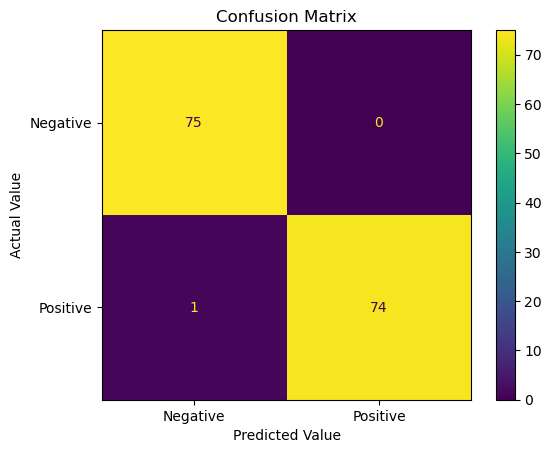

In [70]:
cm = metrics.confusion_matrix(y_test.values.ravel(), y_pred, labels=rf_clf.classes_)
cmplot = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative', 'Positive'])
cmplot.plot()
cmplot.ax_.set(title='Confusion Matrix',xlabel='Predicted Value', ylabel='Actual Value')
plt.show()